In [1]:
# Load libraries
%matplotlib inline
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from scipy import stats, spatial
import string
import functools
import sys
sys.path.append('..')
# import helpers
from matplotlib.cm import get_cmap
cmap = np.array(get_cmap('tab10').colors)

## Load survey responses
Convert all times into seconds 

In [2]:
# Load data
survey = pd.read_excel('Vaximap Survey Responses.xlsx', header=1)
survey = survey.dropna()

# Convert all time durations to seconds 
def to_seconds(dt):
    delta = datetime.timedelta(minutes=dt.minute, seconds=dt.second)
    return delta.total_seconds()

times = survey.loc[:,['Route 1 (5)', 'Route 2 (8)', 'Route 3 (12)', 'Time (13)', 'Time (20)', 'Time (26)']]
survey.loc[:,['Route 1 (5)', 'Route 2 (8)', 'Route 3 (12)', 'Time (13)', 'Time (20)', 'Time (26)']] = times.applymap(to_seconds).astype(float)

# Metadata
print('Dataset shape', survey.shape)

# Inspect
survey.tail(5)

Dataset shape (20, 20)


,Note,Age,Sex,Occupation,Route 1 (5),Route 2 (8),Route 3 (12),List,Route 4.1,Route 4.2,Time (13),Route 5.1,Route 5.2,Route 5.3,Time (20),Route 6.1,Route 6.2,Route 6.3,Route 6.4,Time (26)
15,AJB2,78.0,M,Retired,2100.0,2530.0,375.0,Postcode A-Z,"H,M,I,D,L,C,H","E,F,B,A,G,J,K,E",125.0,"J,O,F,I,R,S,T,J","A,E,N,Q,G,K,A","L,B,P,M,C,D,H,L",260.0,"E,L,F,J,H,K,I,E","D,C,G,B,A,D","V,T,X,U,Y,Z,S,V","N,P,O,Q,M,R,W,N",605.0
16,TK3,30.0,M,IT analyst,191.0,320.0,416.0,Google Maps,"H,M,I,D,L,C,H","G,J,K,E,F,B,A,G",124.0,"O,F,I,R,S,T,J,O","G,K,A,E,N,Q,G","B,P,M,C,D,H,L,B",93.0,"E,L,F,J,H,K,I,E","G,B,A,D,C,G","V,T,X,U,Y,Z,S,V","M,R,W,N,P,O,Q,M",197.0
17,TK4,55.0,M,Company director,168.0,353.0,520.0,Google Maps,"I,D,L,C,M,H,I","G,J,K,E,F,B,A,G",80.0,"I,S,T,J,F,O,I","R,G,K,A,E,N,Q,R","B,P,C,D,M,H,L,B",70.0,"E,L,F,J,H,K,I,E","G,B,A,D,Y,U,C,G","V,T,X,Z,S,V","R,W,N,P,O,Q,M,R",145.0
18,AJB3,55.0,F,Data Engineer,415.0,700.0,370.0,Google Maps,"I,D,L,C,H,M,I","G,A,B,F,E,K,J,G",119.0,"O,F,I,S,T,J,O","Q,N,E,A,K,G,R,Q","B,L,H,D,C,M,P,B",125.0,"E,L,F,J,H,K,I,E","G,C,D,A,B,G","M,Q,O,N,P,W,R,M","V,T,X,U,Y,Z,S,V",121.0
19,AJB4,26.0,F,Physiotherapist,115.0,130.0,345.0,Apple Maps,"G,J,K,E,F,B,A,G","D,I,M,H,C,L,D",40.0,"P,M,C,D,H,L,B,P","A,E,N,Q,R,G,K,A","I,S,T,J,O,F,I",98.0,"E,L,F,J,H,K,I,E","G,B,A,D,C,G","R,M,Q,O,N,P,W,R","V,T,X,S,Z,U,Y,V",179.0


In [3]:
# Check the routes of each survey respondent are complete (they contain all the letters we expect)
letter2index = dict(zip(string.ascii_uppercase, np.arange(26)))
index2letter = list(string.ascii_uppercase)

def get_route_length_from_dist_mat(route, dm):
    route = route.split(',')
    if (route[0] != route[-1]) or len(route) > 8: 
        raise RuntimeError("Route error (start/end or length > 7?)", route)
    inds = [ letter2index[i] for i in route ]
    total = sum([ dm[inds[x], inds[x+1]] for x in range(len(inds) - 1) ])
    total += dm[inds[-1], inds[0]]
    return total 

def check_solutions_complete(df, target):
    for row in range(df.shape[0]):
        flat = [] 
        for r in df.iloc[row,:]: 
            flat += r.split(',')
        flat = set(flat)
        for idx in range(target):
            if not index2letter[idx] in flat: 
                raise RuntimeError(f"{df.columns[0][:-2]} for index {df.iloc[row,:].name} incomplete, {index2letter[idx]} missing")


In [4]:
# Cohort chracteristics 
print('Age: mean', round(survey.Age.mean(),1), ', std', round(survey.Age.std(),1), 
      ', min',round(survey.Age.min(),1), ', max', round(survey.Age.max(),1))
print('Participants: ', survey.shape[0], 'total,', (survey.Sex == 'F').sum(), 'female')

Age: mean 45.0 , std 19.2 , min 26.0 , max 78.0
Participants:  20 total, 8 female


## Regressions
How long does it take people to generate a spatial representation or produce a route?

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Look up time: LinregressResult(slope=36.40427072023164, intercept=19.27886355410783, rvalue=0.7793916985544531, pvalue=7.388172269000272e-16, stderr=3.4977941338961087, intercept_stderr=26.69575512195947)
Planning: LinregressResult(slope=4.771736713364467, intercept=-1.4525609665703314, rvalue=0.7571587296546988, pvalue=1.409103363335895e-14, stderr=0.49204776588455834, intercept_stderr=8.680843851124463)


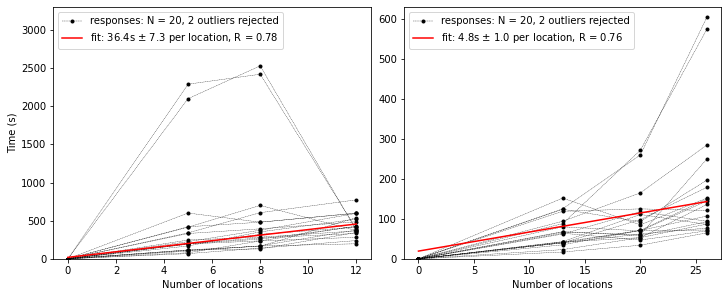

In [6]:
# Get time to complete Questions 1-3
# Detect outliers, set manual threshold as 2000s here 
lookup_time = survey.loc[:,['Route 1 (5)', 'Route 2 (8)', 'Route 3 (12)']].values.astype(float)
lookup_time = np.hstack((np.zeros((lookup_time.shape[0], 1)), lookup_time))
route_size = np.tile([0,5,8,12], (lookup_time.shape[0], 1))

# Do regression, exlcuding outliers 
fltr = (lookup_time < 2000).all(1)
lut_reg = stats.linregress(route_size[fltr,:].flatten(), lookup_time[fltr,:].flatten())

# Calculate 95% interval on slope 
tinv = lambda p, df: abs(stats.t.ppf(p/2, df))
ci = tinv(0.05, len(route_size)-2) * lut_reg.stderr

fig, axes = plt.subplots(1, 2, constrained_layout=True, figsize=(10,4))

ax = axes[0]
# Plot data and linear fit
for row in range(lookup_time.shape[0]):
    label = f'responses: N = {fltr.size}, {(~fltr).sum()} outliers rejected' if row == 0 else None
    ax.plot(route_size[row], lookup_time[row], 'k--', linewidth=0.33, marker='.', label=label)
route_size_fit = np.linspace(0,12)
lookup_time_fit = lut_reg.intercept + (route_size_fit * lut_reg.slope)
ax.plot(route_size_fit, lookup_time_fit, 'r-', label=r'fit: %.1fs $\pm$ %.1f per location, R = %.2f' % (lut_reg.slope, ci, lut_reg.rvalue))
ax.legend(loc='upper left')
ax.set_ylabel('Time (s)')
ax.set_xlabel('Number of locations')
# ax.set_title(f'Time to generate spatial representation (N = {fltr.size})')
ax.set_ylim(0,3300)

# Print coefficients
print("Look up time:", lut_reg)

# Get time to complete Questions 4-6
planning_time = survey.loc[:,['Time (13)', 'Time (20)', 'Time (26)']].values.astype(float)
planning_time = np.hstack((np.zeros((planning_time.shape[0], 1)), planning_time))
route_size = np.tile([0,13,20,26], (planning_time.shape[0], 1))

# Do regression, exlcuding outliers 
fltr = (planning_time < 400).all(1)
planning_reg = stats.linregress(route_size[fltr,:].flatten(), planning_time[fltr,:].flatten())

# Calculate 95% interval on slope 
tinv = lambda p, df: abs(stats.t.ppf(p/2, df))
ci = tinv(0.05, len(route_size)-2) * planning_reg.stderr

# Plot data and linear fit
ax = axes[1]
for row in range(planning_time.shape[0]):
    label = f'responses: N = {fltr.size}, {(~fltr).sum()} outliers rejected' if row == 0 else None
    ax.plot(route_size[row], planning_time[row], 'k--', linewidth=0.33, marker='.', label=label)
route_size_fit = np.linspace(0,26)
planning_time_fit = lut_reg.intercept + (route_size_fit * planning_reg.slope)
ax.plot(route_size_fit, planning_time_fit, 'r-', label=r'fit: %.1fs $\pm$ %.1f per location, R = %.2f' % (planning_reg.slope, ci, planning_reg.rvalue))
ax.legend()
# ax.set_ylabel('Time (s)')
ax.set_xlabel('Number of locations')
# ax.set_title(f'Time to generate routes (N = {fltr.size})')
ax.set_ylim(0,630)
fig.savefig('../paper/figs/survey_regressions.eps', dpi=250, bbox_inches='tight')

print("Planning:", planning_reg)